In [ ]:
pip install yfinance

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import datetime as dt
from pathlib import Path
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
plt.close('all')
import yfinance as yf
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
xrp_1d = yf.download(tickers='XRP-USD', start='2019-09-01', end = '2021-08-11', interval='1d')
xrp_1d.drop(columns = ['Open','High','Low','Adj Close','Volume'], inplace = True)
#xrp_1hr.reset_index(inplace=True)
#xrp_1hr.rename(columns = {'index':'Datetime'}, inplace = True)
#xrp_1hr.set_index(pd.to_datetime(xrp_1hr['Datetime'],infer_datetime_format=True),inplace=True)
xrp_1d.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2019-09-01,0.258054
2019-09-02,0.260820
2019-09-03,0.263139
2019-09-04,0.259905
2019-09-05,0.256346


In [ ]:
import datetime as dt
import matplotlib.pyplot as plt
plt.close("all")

In [ ]:
xrp_diff = xrp_1d['Close'].diff()
xrp_diff

Date
2019-09-01         NaN
2019-09-02    0.002766
2019-09-03    0.002319
2019-09-04   -0.003234
2019-09-05   -0.003559
                ...   
2021-08-07    0.069768
2021-08-08   -0.037542
2021-08-09    0.039814
2021-08-10    0.032694
2021-08-11    0.161277
Name: Close, Length: 707, dtype: float64

In [ ]:
up = xrp_diff.clip(lower=0)
down = -1*xrp_diff.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
rs

Date
2019-09-01          NaN
2019-09-02         -inf
2019-09-03         -inf
2019-09-04    10.990447
2019-09-05     5.029593
                ...    
2021-08-07     2.342294
2021-08-08     1.651061
2021-08-09     1.988104
2021-08-10     2.286164
2021-08-11     3.869569
Name: Close, Length: 707, dtype: float64

In [ ]:
xrp_1d['RSI'] = 100 - (100/(1 + rs))
xrp_1d['RSI']
xrp_1d

,Close,RSI
Date,,
2019-09-01,0.258054,NaN
2019-09-02,0.260820,100.000000
2019-09-03,0.263139,100.000000
2019-09-04,0.259905,91.660027
2019-09-05,0.256346,83.415133
...,...,...
2021-08-07,0.816281,70.080433
2021-08-08,0.778739,62.279250
2021-08-09,0.818553,66.533965


In [ ]:
#xrp_1d_rsi=xrp_1d.iloc[: , 1:]
#print(xrp_1d_rsi)

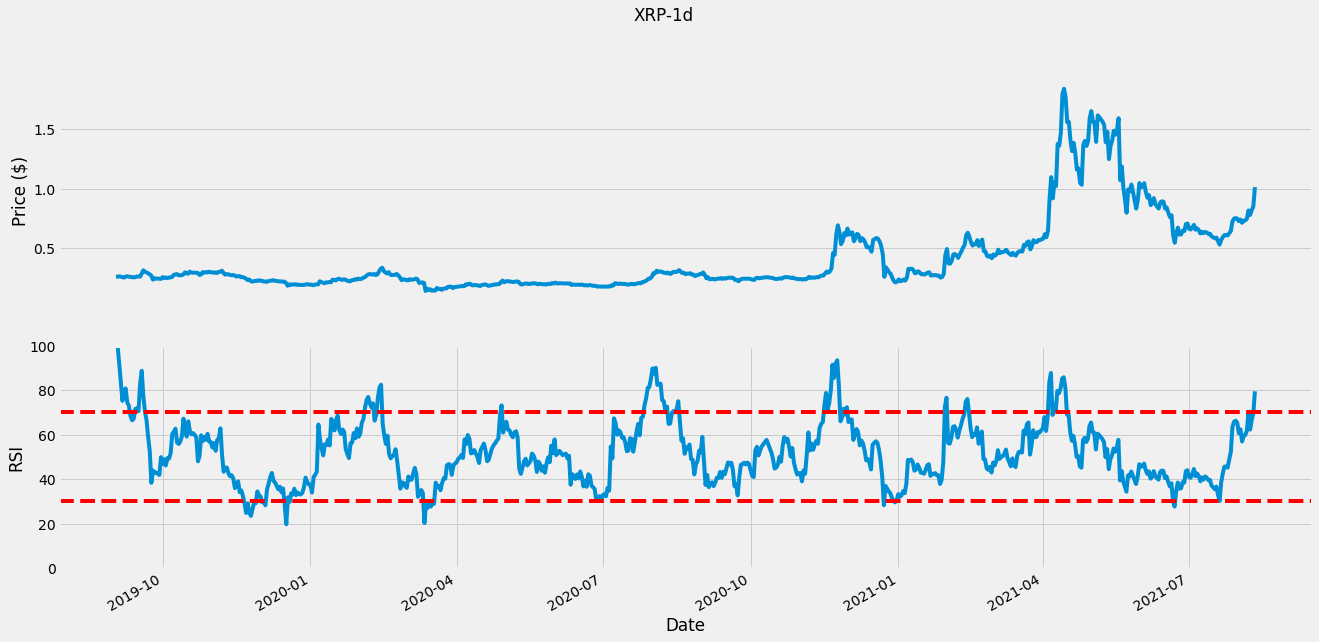

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)
fig.suptitle('XRP-1d')
xrp_1d['Close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')
xrp_1d['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color='r', linestyle='--')
ax2.axhline(70, color='r', linestyle='--')
ax2.set_ylabel('RSI')

plt.show()

In [ ]:
# TRADE STRATEGY BASED ON RSI
def implement_rsi_strategy(prices, rsi):
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if rsi[i] >= 70 :
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i] <= 30:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

buy_price, sell_price, rsi_signal = implement_rsi_strategy(xrp_1d['Close'], xrp_1d['RSI'])

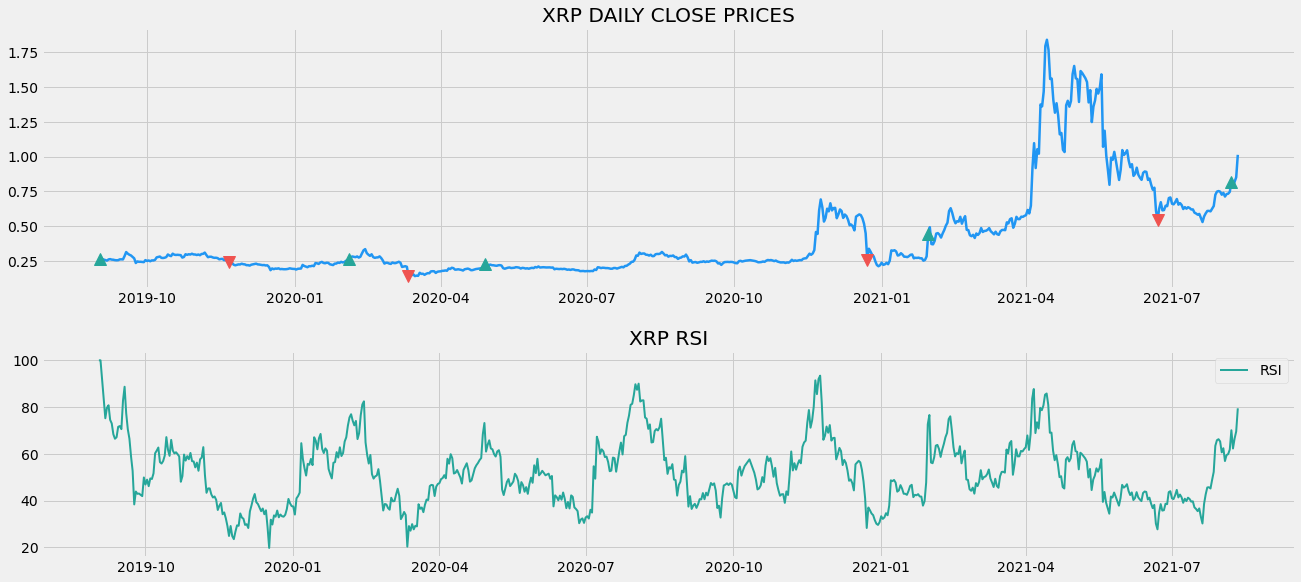

In [ ]:
# PLOTTING TRADE SIGNALS FOR SQ AROON 25 STRATEGY
df = xrp_1d
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(df['Close'], linewidth = 2.5, color = '#2196f3')
ax1.plot(df.index, buy_price, marker = '^', color = '#26a69a', markersize = 12)
ax1.plot(df.index, sell_price, marker = 'v', color = '#ef5350', markersize = 12)
ax1.set_title('XRP DAILY CLOSE PRICES')
ax2.plot(df['RSI'], color = '#26a69a', linewidth = 2, label = 'RSI')
ax2.legend()
ax2.set_title('XRP RSI')
plt.show()

In [ ]:
# CREATING POSITION FOR SQ BASED ON AROON 25 SIGNALS
position = []

for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = df['RSI']
close_price = df['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(df.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,RSI,rsi_signal,rsi_position
Date,,,,
2019-09-01,0.258054,NaN,0,1
2019-09-02,0.260820,100.000000,1,1
2019-09-03,0.263139,100.000000,0,1
2019-09-04,0.259905,91.660027,0,1
2019-09-05,0.256346,83.415133,0,1
...,...,...,...,...
2021-08-07,0.816281,70.080433,1,1
2021-08-08,0.778739,62.279250,0,1
2021-08-09,0.818553,66.533965,0,1


In [ ]:
# BACKTESTING THE SQ AROON TRADE STRATEGY
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in XRP : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in XRP : 18841.51
Profit percentage of the RSI strategy : 18%


In [ ]:
strategy.to_csv('XRP_DAILY_RSI_TRADE_STRATEGY.CSV')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>